In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import sklearn
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
model = SentimentIntensityAnalyzer()

# Part 1
h_news = pd.read_csv('hn_items.csv',delimiter=',',encoding='utf-8')
text_only = h_news.dropna(subset=['text'], how='all')['text'].values

h_news_final = pd.DataFrame(columns = ['text', 'pos', 'neg'])
with_values = []

for text in text_only:
    res = model.polarity_scores(text)
    with_values.append({'text': text, 'pos': res['pos'], 'neg': res['neg']})

h_news_final =  h_news_final.append(with_values)
print('5 most positive')
print(h_news_final.nlargest(5, 'pos'))
print('5 most negative')
print(h_news_final.nlargest(5, 'neg'))
print('#############################')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vagrant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
5 most positive
                text  pos  neg
605             sure  1.0  0.0
999              ha!  1.0  0.0
1307      Beautiful.  1.0  0.0
1628  Great, thanks!  1.0  0.0
1902            True  1.0  0.0
5 most negative
             text  pos  neg
512          dupe  0.0  1.0
1797         spam  0.0  1.0
2962          No.  0.0  1.0
3008       dupe.   0.0  1.0
3014  desperation  0.0  1.0
#############################


0.0253648478208
0.0354432599956
0.0184044740546
0.0321851452339
0.0317072314033
0.0155680458133
0.0379843333167
0.0238278956546
0.0186940700512
0.0120846728743


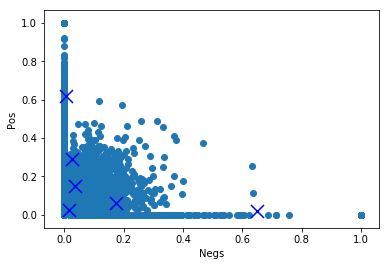

In [3]:

# Part 2

negs = h_news_final['neg']
pos =  h_news_final['pos']

from sklearn.cluster import KMeans
    
folds = KFold(n_splits=10)
k_means = KMeans(n_clusters=6)

xs = negs.values
ys = pos.values

xy = np.stack((xs, ys), axis=1)

for train, test in folds.split(xs, ys):
    x_train, x_test = xs[train].reshape(-1, 1), xs[test].reshape(-1, 1)
    y_train , y_test = ys[train].reshape(-1, 1), ys[test].reshape(-1, 1)
    xy_fold = xy[train]
    
    reg = linear_model.LinearRegression()
    reg.fit(x_train, y_train)
    
    predict = reg.predict(x_test)

    print(metrics.r2_score(y_test, predict))
    
    k_means.fit(xy_fold)

    # Plot the centroids as a white X
centroids = k_means.cluster_centers_
plt.xlabel('Negs')
plt.ylabel('Pos')
plt.scatter(xs[train], ys[train])
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='b', zorder=10)

plt.show()

In [5]:
# Part 3

import folium
from folium.plugins import HeatMap
import zipfile
import pandas as pd

with zipfile.ZipFile("boliga.zip") as zip:
       with zip.open("boliga_zealand.csv") as myZip:
        boliga = pd.read_csv(myZip).drop(['Index', '_1', 'Unnamed: 0'], axis=1)
        zip_df = pd.DataFrame(boliga['zip_code'].str.split(' ',1).tolist(), columns = ['zip','city'])
        boliga = boliga.assign(zip_int=zip_df['zip'])
        boliga = boliga[boliga['zip_int'].astype(int) <= 2999]
        boliga['zip_int'] = pd.to_numeric(boliga['zip_int'], errors='coerce')
        heatmap_df = boliga[['lon','lat','price']].dropna()

radhusplads = (55.676098, 12.568337)
boliga_map = folium.Map(location=[55.676098, 12.568337], zoom_start=11)

folium.Marker(location=radhusplads, icon=folium.Icon(color='red',icon='home')).add_to(boliga_map)
heat_data = [(e.lat,e.lon,float(e.price)) for e in heatmap_df.itertuples()]
HeatMap(heat_data, radius=7).add_to(boliga_map)
boliga_map.save('heatmap.html')

# From our heatmap we can see that when zoomed out, it is clear that a triangled shape covers the areas of
# Vanløse, Brønshøj, and Valby. The yellow colour on our heatmap reveals any low prices, and this is prominent
# in our triangle. We know that these city areas all have really good connections to the city, as well as outwards
# and this is very important to people 

In [7]:
# Part 4

import math
def haversine_distance(origin, destination):

    lat_orig, lon_orig = origin
    lat_dest, lon_dest = destination
    radius = 6371

    dlat = math.radians(lat_dest-lat_orig)
    dlon = math.radians(lon_dest-lon_orig)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat_orig)) 
        * math.cos(math.radians(lat_dest)) * math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

Norreport = (55.683333, 12.571667)

haversine_df = boliga.dropna()

haversine_df = haversine_df.assign(km_to_cph=haversine_df.apply(lambda row: haversine_distance((row['lat'],row['lon']),Norreport),axis=1))
#haversine_df[:5]


In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import numpy as np

model = linear_model.LinearRegression()

X = haversine_df['km_to_cph'].astype(float).values.reshape(-1,1)
Y = haversine_df['price'].astype(int).values.reshape(-1,1)
Z = haversine_df['size_in_sq_m'].astype(float).values.reshape(-1,1)

from math import sqrt

folds = KFold(n_splits=10)

metrics_df = pd.DataFrame(columns=['Mean Average Error','Root Mean Square Error','Pearson','Coefficients','Intercept'])

metrics_results = []

for train_idx, test_idx in folds.split(X, Y, Z):
    XZ_variables = np.stack([X ,Z], axis=1).reshape(-1,2)
    XZ_train, XZ_test = XZ_variables[train_idx], XZ_variables[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    model = linear_model.LinearRegression()
    
    model.fit(XZ_train, Y_train)
    
    pred = model.predict(XZ_test)
    
    MAE = str(metrics.mean_absolute_error(Y_test,pred))
    RMSE = str(sqrt(metrics.mean_squared_error(Y_test,pred)))
    Pearson = str(metrics.r2_score(Y_test, pred))
    coef = str(model.coef_)
    intercept = str(model.intercept_)
    
    metrics_results.append({'Mean Average Error':MAE,'Root Mean Square Error':RMSE,'Pearson':Pearson,'Coefficients':coef,'Intercept':intercept})

metrics_df = metrics_df.append(metrics_results)
    
metrics_df

,Mean Average Error,Root Mean Square Error,Pearson,Coefficients,Intercept
0,1151010.15013,1968637.6274928295,0.252588434168,[[-51627.53478002 21873.67087649]],[ 468967.86103761]
1,1112714.78146,2105200.6853113417,0.200129185358,[[-56289.28739035 22426.28745256]],[ 475847.64950338]
2,1036684.38712,1894099.141052513,0.253664364509,[[-55157.89312618 22238.41605402]],[ 479005.70158994]
3,777520.858101,1293465.4931107536,0.310464108278,[[-57376.07833908 22037.52332194]],[ 538315.68708767]
4,769573.931188,1264603.643452855,0.344616927525,[[-56630.12299292 22030.18796333]],[ 528846.86729399]
5,828741.685649,1526332.408612075,0.127381807962,[[-57879.34813745 22463.39573181]],[ 524560.46077794]
6,870587.346337,1432430.6889074747,-0.248792858961,[[-51577.27294029 23020.388222 ]],[ 446557.76393754]
7,962255.972591,1943068.0516709576,-0.0605250906322,[[-58436.39622701 23216.84143493]],[ 444005.65273246]
8,1114148.51487,1689807.3800089294,0.245376067802,[[-59268.55904817 22525.65960133]],[ 496345.55264917]
9,1561831.59719,3158180.347585001,0.194886405584,[[-65692.27898799 20193.22273316]],[ 704897.77968146]


In [ ]:
# Anytime that we have such huge figures for the errors, we know that our model must be bad. It is also common
# sense, because we know that two areas could be the same distance from the city, but have very different levels
# of wealth. So it makes sense that property size and distance won't give us an accurate model.
# So no, the model won't help us to intuit how to shop for housing. If anything it's unhelpful.
# The heatmap is likely to give a much better idea of where housing is more affordable.